# Astrometric analysis with ePSF

In this directory, the data calculated with ctl2.json are examined.

Conditions: Real PSF, No Flat, No ACE, No WFE, w/o detector offset.

This is basically the same analysis as analysis02 and analysis02again.

We focus on the analysis of 13.0-mag data and investigate the parameter dependency of the results.

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

## Defining a function

The EPSFBuilder function takes many parameters. Among them, the following parameters seem to be important: maxiters, norm_radius, shift_val, recentering_boxsize, and center_accuracy. Howver, by investigating the source code, shift_val does not seem to be used in the default settings (default centroid_func, centroid_com). In our analysis, a positional accuracy of about 0.01 pixels is needed. Then we fix the center_accuracy parameter to 0.001. Therefore, we investigate the dependency on the other parameters (i.e., maxiters, norm_radius, and recentering_boxsize).

In [2]:
def func(filename, sp_filename, n_oversample, n_maxiter, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    n_oversample: Oversampling setting for ePSF analysis.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
#    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
    mag = 13.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
    plt.xlim([-0.01,0.04])
    plt.ylim([-0.01,0.04])
    plt.show()
    
    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.01,0.04])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()
    
#    plt.axes().set_aspect('equal')
#    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#               angles='xy', scale_units='xy', scale=0.0003)
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.xlim([0, 1920])
#    plt.ylim([0, 1920])
#    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
    meandx = np.mean(dx)
    meandy = np.mean(dy)
    return stddx, stddy, stddr, meandx, meandy

## Number of iterations and positional deviations

We check the changes of the created ePSF and positional deviations in the iteration. We analyze image.12.0.00.fits, here.

Iteration 1...


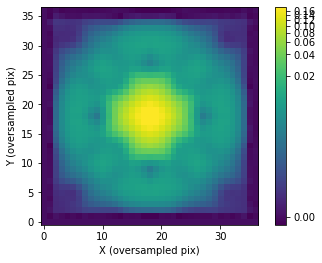

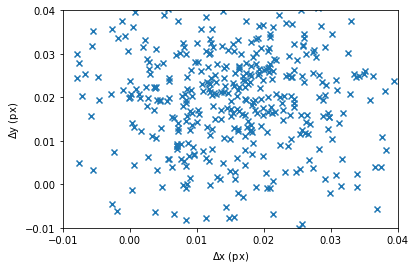

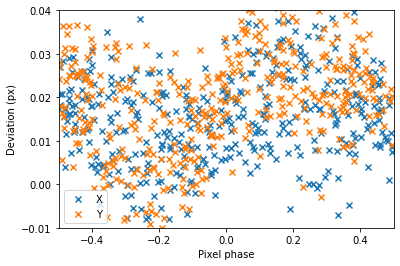

Iteration 2...


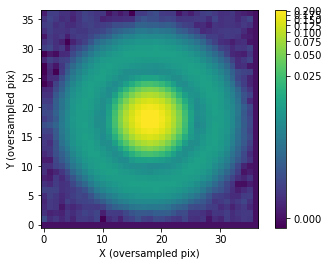

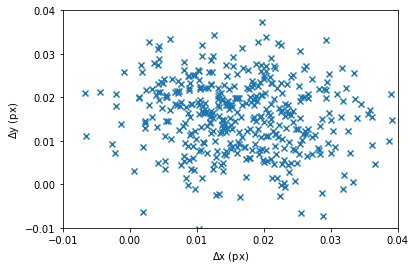

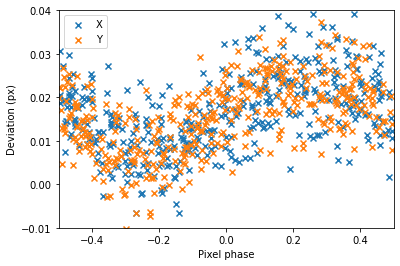

Iteration 3...


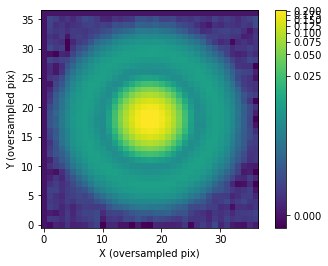

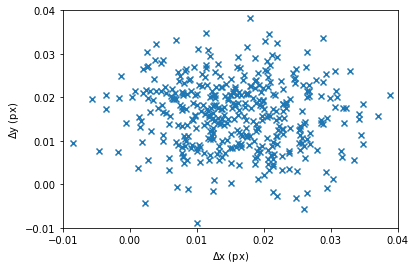

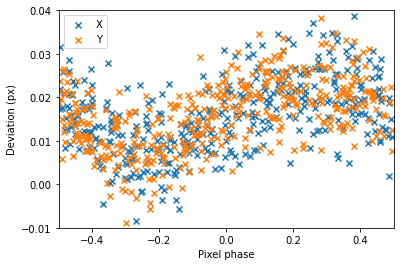

Iteration 4...


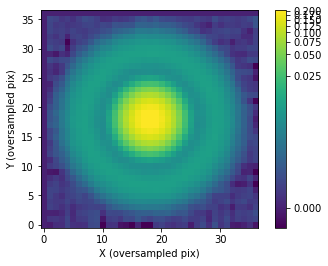

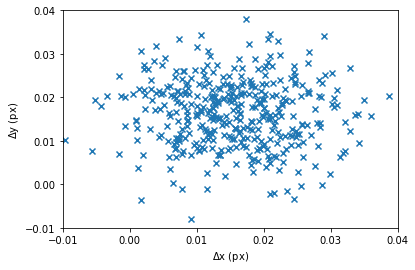

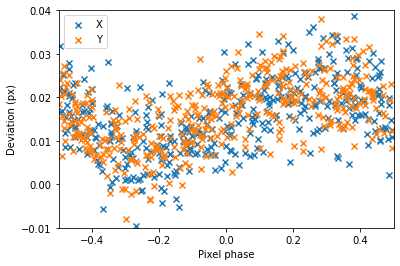

Iteration 5...


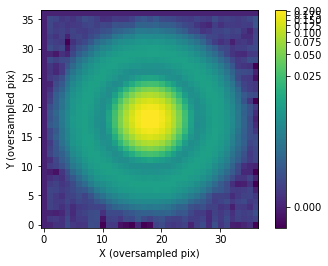

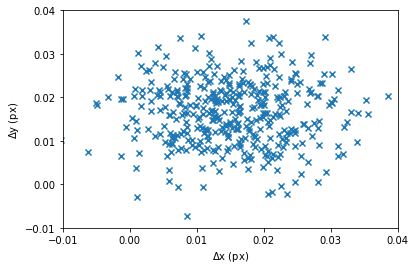

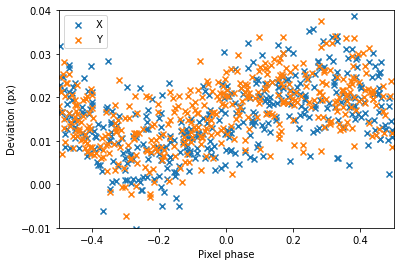

Iteration 6...


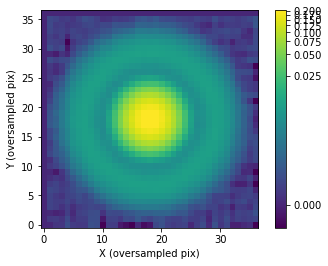

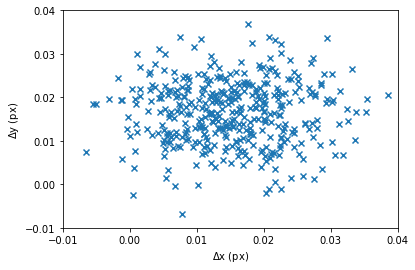

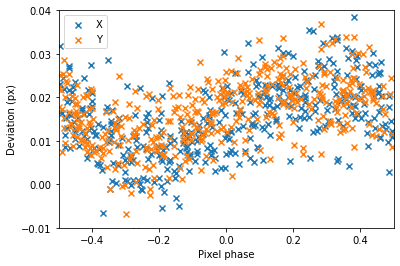

Iteration 7...


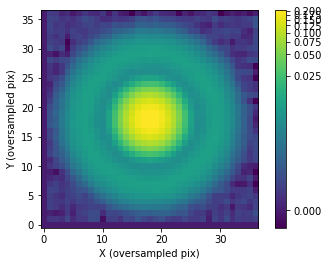

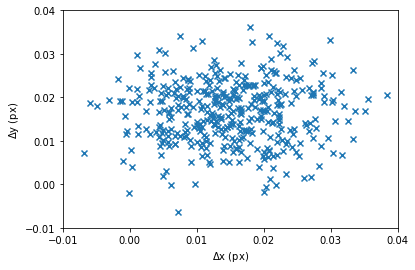

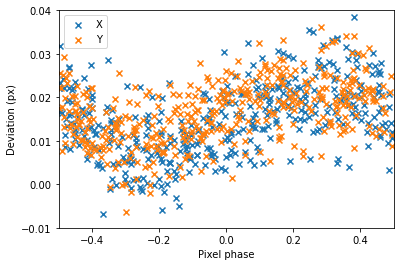

Iteration 8...


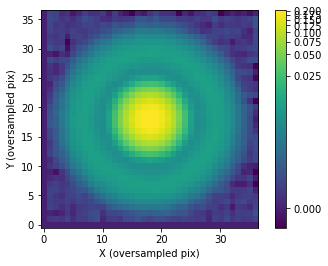

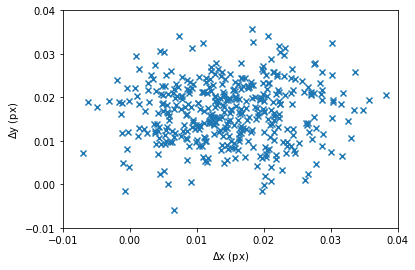

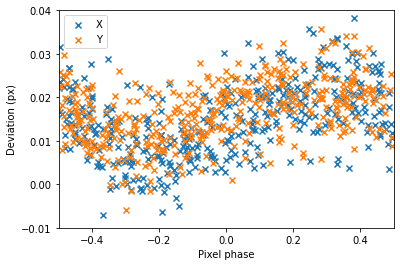

Iteration 9...


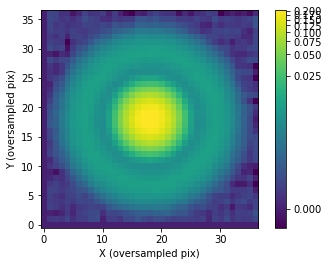

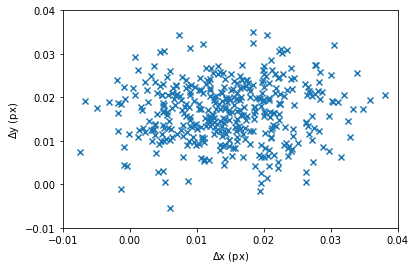

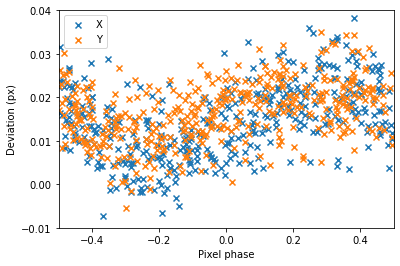

Iteration 10...


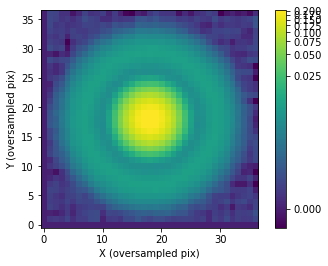

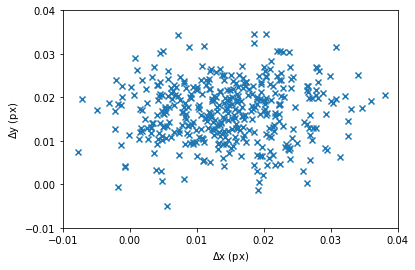

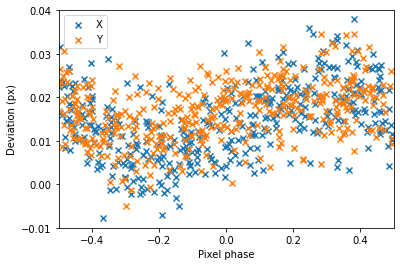

[0.010069902899893554, 0.007626361822287272, 0.007421855783590792, 0.007419095913609285, 0.007437650687103506, 0.0074564640749717696, 0.00746976052154922, 0.0074757973804494265, 0.007464845468386046, 0.007447369053312525]


In [3]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.13.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 4, i, norm_radius=5.5, recentering_boxsize=5)
    tmp.append(sr)
print(tmp)

In the first iteration, the ePSF shows a strange pattern which is not seen in the true PSF, and the deviations from true positions are around 0.02 p/m 0.02-0.03 px. A systematic offset of 0.02 px is seen.

In the second iteration, the ePSF becomes a smooth symmetric pattern which consists of a central core and a ring. These structures are also seen in the true PSF. Therefore, we can say that the ePSF is correctly updated. The deviation plotted againast pixel phases shows a significant reduction of the scatter. Therefore, the star positions seem to be also updated correctly. However, a systematic fluctuation is left in the deviation vs. pixel phase plot. This seems to be the same pattern as the pixel-phase error in the Anderson and King 2000.

In the following iterations, the pixel-phase error does not seem to be corrected. The reason is also pointed out by Anderson and King 2000 that we cannot correct the star positions without correctly dithered data which enable us to eliminate the systematic pixel-phase error. In such a case, the ePSF and the star positions are thought to be converged to incorrect ones. A large number of iterations will not effectively improve the positions, and the positional accuracy will be limited by the pixel-phase error. Such a limit is thought to be seen in the previous error analysis.

## Recentering_boxsize = 9

In [4]:
def func(filename, sp_filename, n_oversample, n_maxiter, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    n_oversample: Oversampling setting for ePSF analysis.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
#    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
    mag = 13.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
#    plt.xlim([-0.01,0.04])
#    plt.ylim([-0.01,0.04])
    plt.show()
    
    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
#    plt.xlim([-0.5,0.5])
#    plt.ylim([-0.01,0.04])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()
    
#    plt.axes().set_aspect('equal')
#    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#               angles='xy', scale_units='xy', scale=0.0003)
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.xlim([0, 1920])
#    plt.ylim([0, 1920])
#    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
    meandx = np.mean(dx)
    meandy = np.mean(dy)
    return stddx, stddy, stddr, meandx, meandy

Iteration 1...


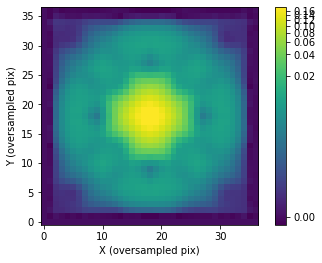

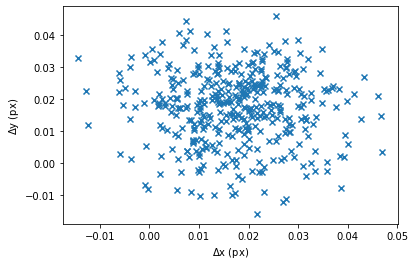

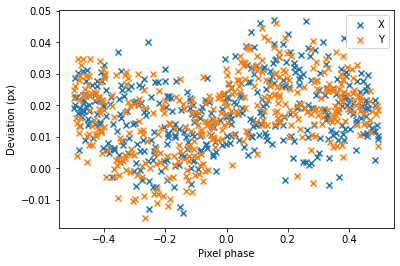

Iteration 2...


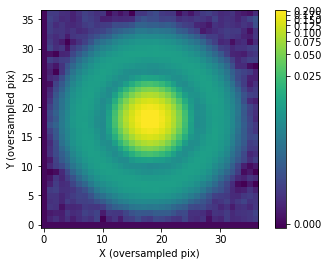

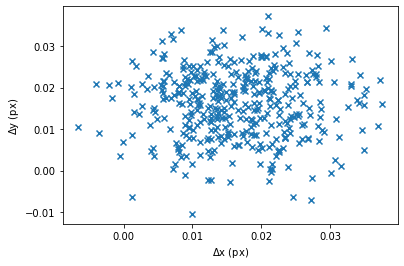

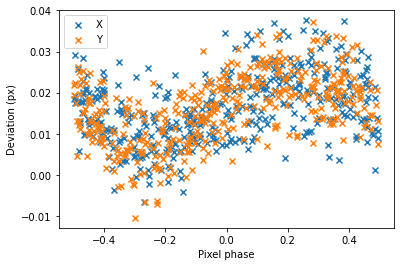

Iteration 3...


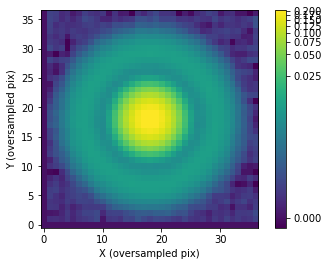

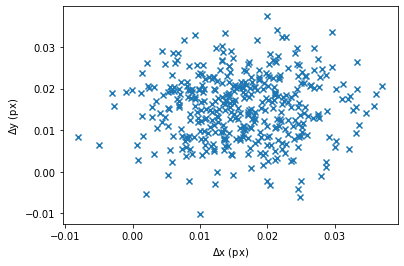

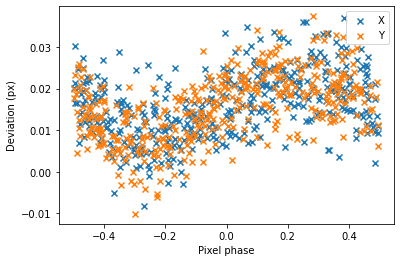

Iteration 4...


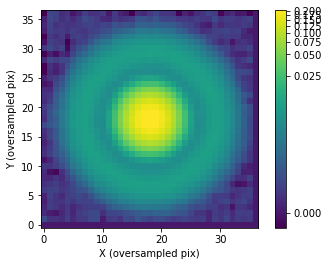

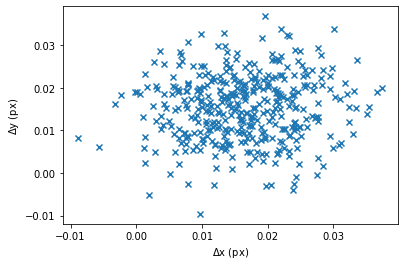

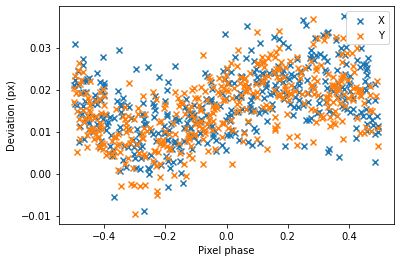

Iteration 5...


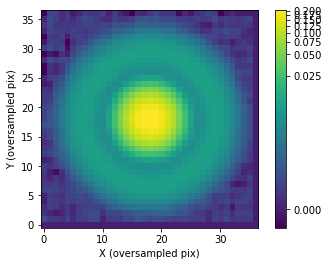

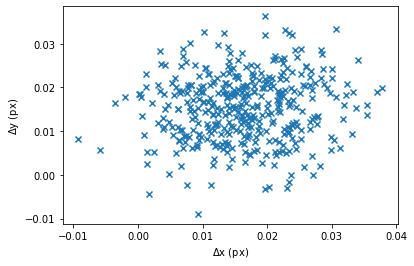

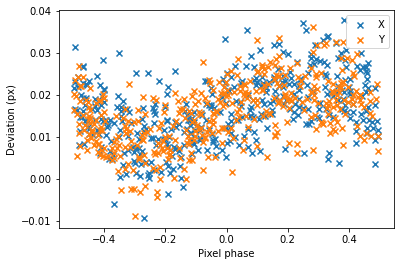

Iteration 6...


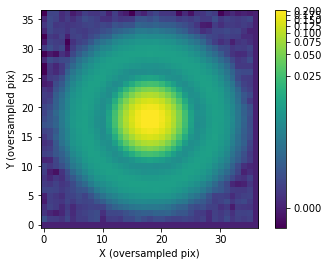

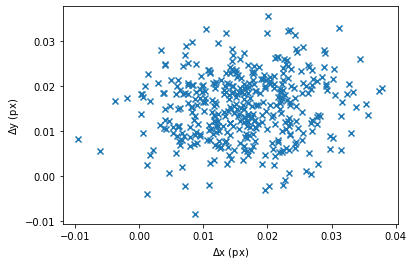

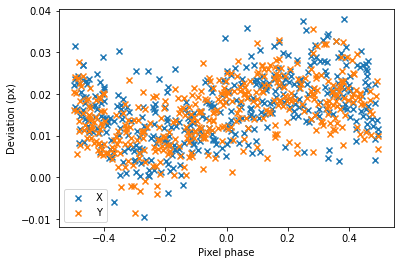

Iteration 7...


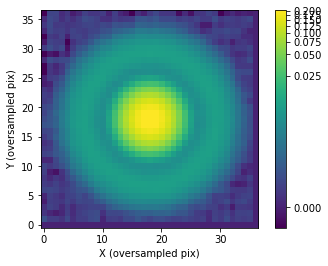

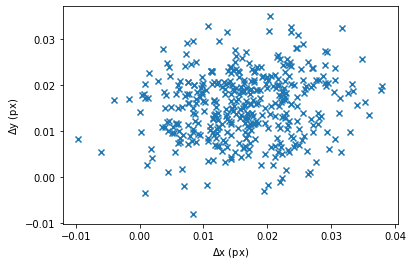

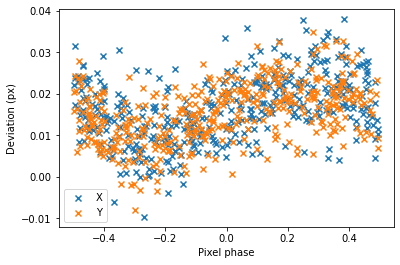

Iteration 8...


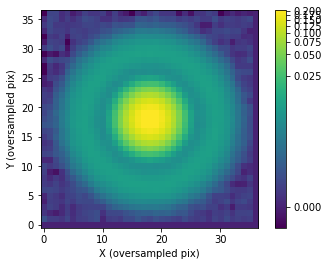

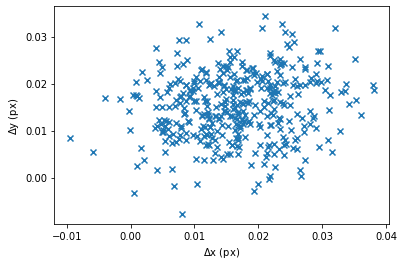

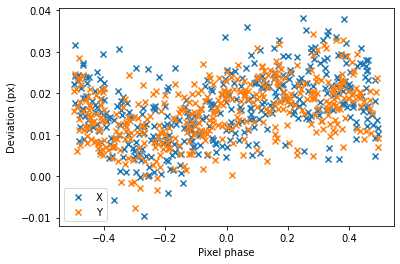

Iteration 9...


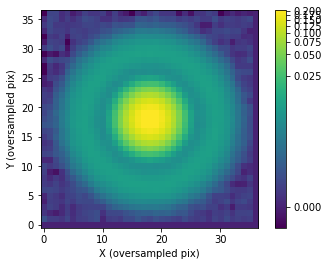

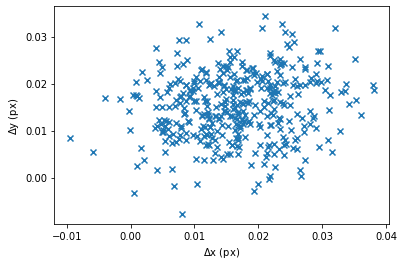

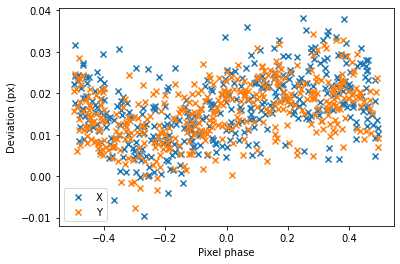

Iteration 10...


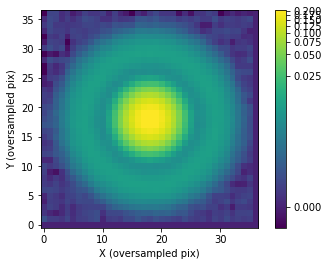

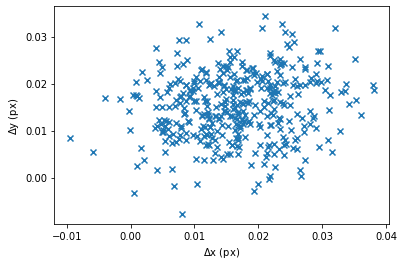

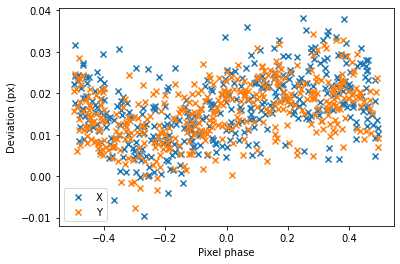

[0.009921560601640296, 0.007833061144505576, 0.007641991953712987, 0.007646625711287751, 0.00768091075188724, 0.0077066129601633775, 0.0077331241361397254, 0.007759880981389668, 0.007759880981389668, 0.007759880981389668]


In [5]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.13.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 4, i, norm_radius=5.5, recentering_boxsize=9)
    tmp.append(sr)
print(tmp)

## Recentering_boxsize = 3

Iteration 1...


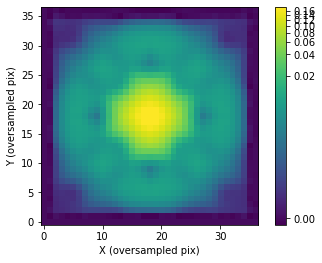

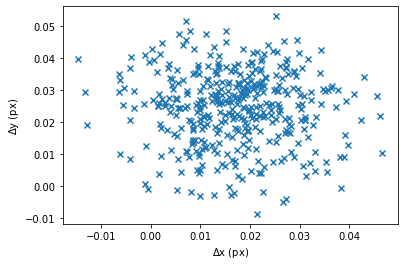

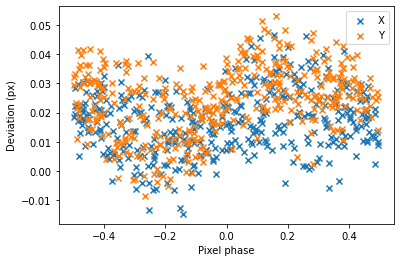

Iteration 2...


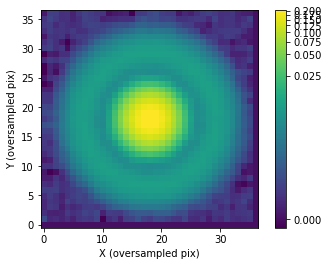

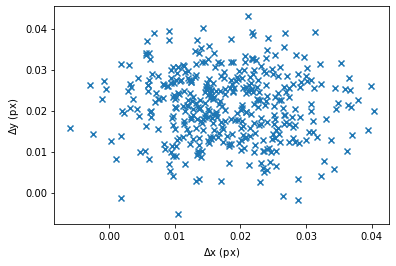

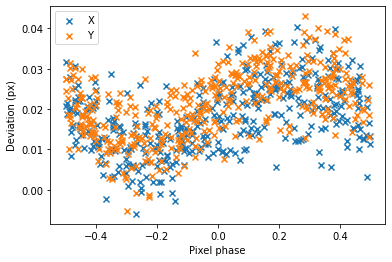

Iteration 3...


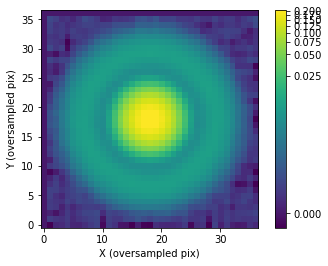

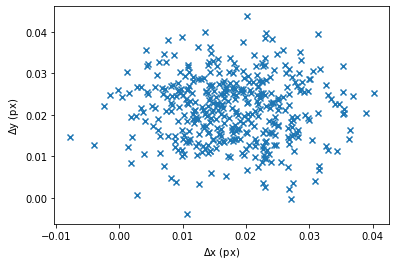

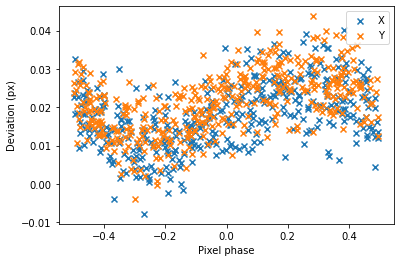

Iteration 4...


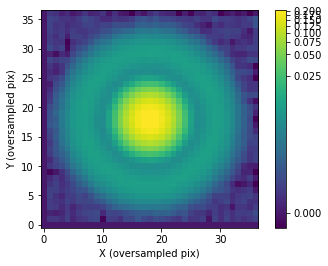

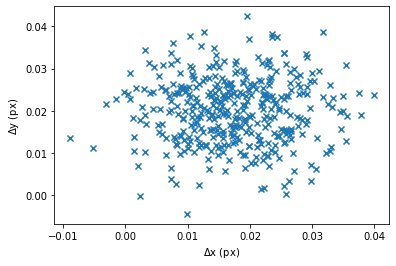

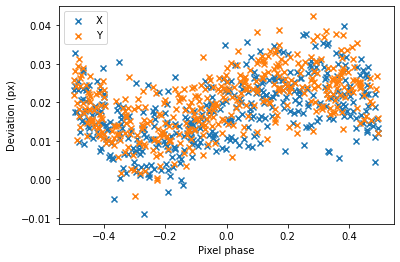

Iteration 5...


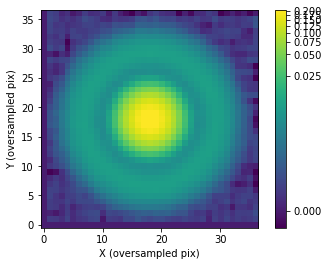

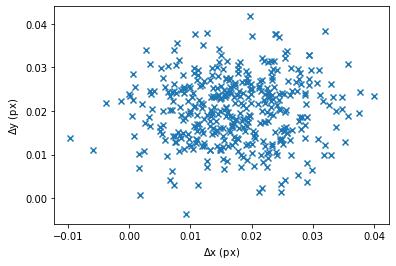

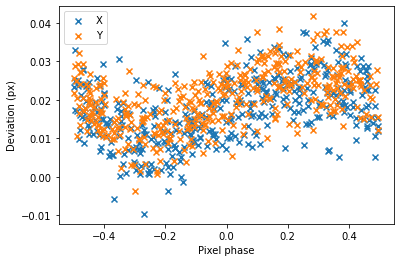

Iteration 6...


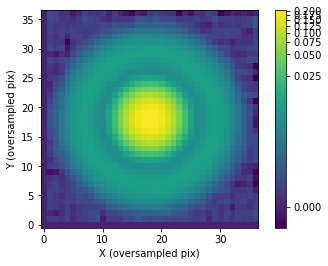

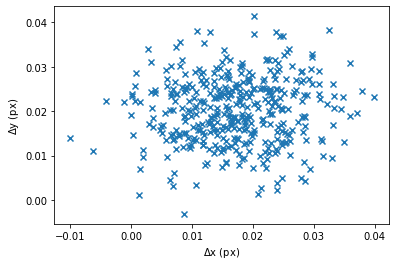

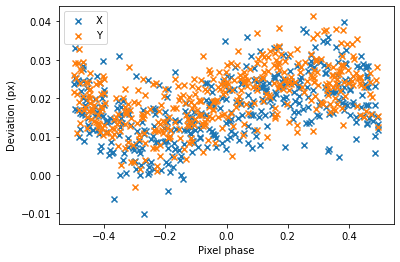

Iteration 7...


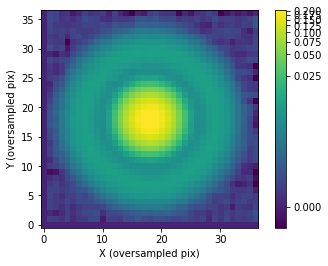

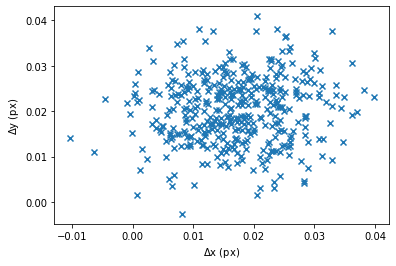

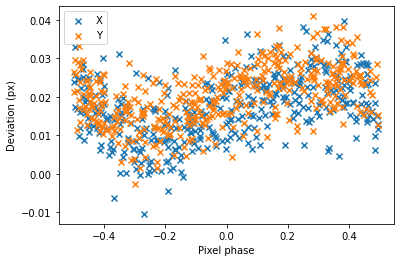

Iteration 8...


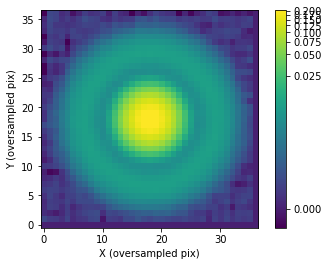

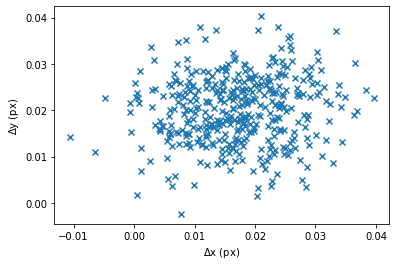

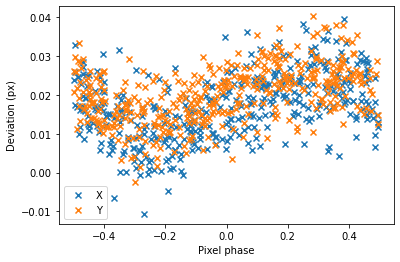

Iteration 9...


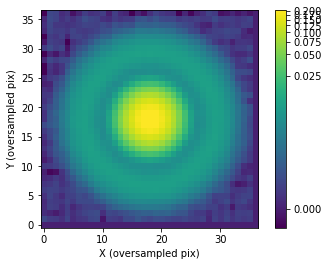

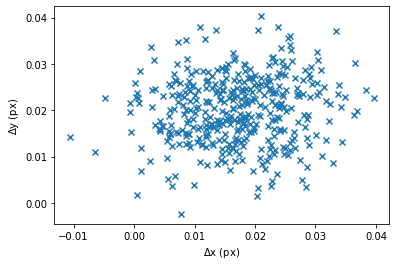

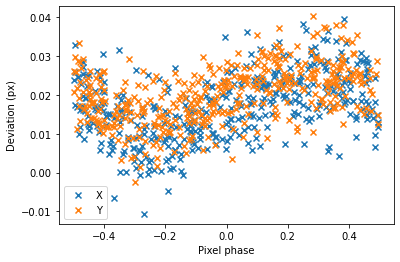

Iteration 10...


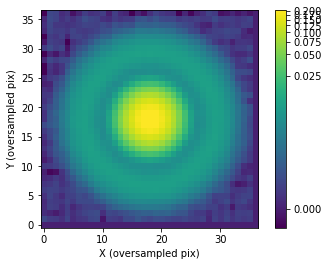

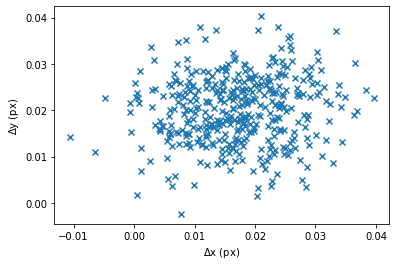

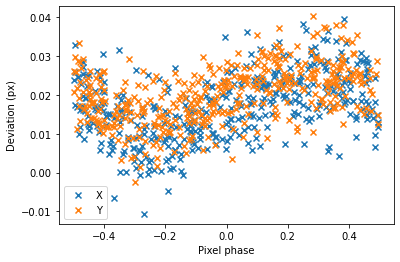

[0.010507772087850442, 0.008028598923084971, 0.007791938405835557, 0.007783064835331695, 0.0078092680712675945, 0.00784066872722401, 0.0078647753464276, 0.007875894669579003, 0.007875894669579003, 0.007875894669579003]


In [6]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.13.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 4, i, norm_radius=5.5, recentering_boxsize=3)
    tmp.append(sr)
print(tmp)

## Recentering_boxsize dependency

In [7]:
def func(filename, sp_filename, n_oversample, n_maxiter, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    n_oversample: Oversampling setting for ePSF analysis.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
#    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
    mag = 13.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
#    plt.scatter(dx, dy, marker='x')
#    plt.xlabel('$\Delta$x (px)')
#    plt.ylabel('$\Delta$y (px)')
#    plt.xlim([-0.01,0.04])
#    plt.ylim([-0.01,0.04])
#    plt.show()
    
    # Making pix-phase error data.
#    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
#    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
#    plt.xlim([-0.5,0.5])
#    plt.ylim([-0.01,0.04])
#    plt.xlabel('Pixel phase')
#    plt.ylabel('Deviation (px)')
#    plt.legend()
#    plt.show()
    
#    plt.axes().set_aspect('equal')
#    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#               angles='xy', scale_units='xy', scale=0.0003)
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.xlim([0, 1920])
#    plt.ylim([0, 1920])
#    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
    meandx = np.mean(dx)
    meandy = np.mean(dy)
    return stddx, stddy, stddr, meandx, meandy

Recentering boxsize 3...


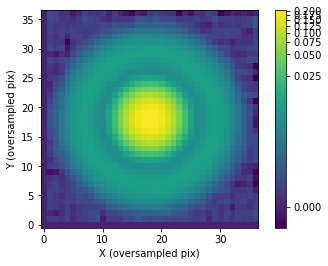

Recentering boxsize 4...


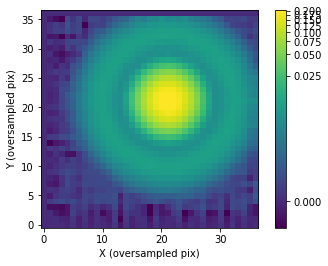

Recentering boxsize 5...


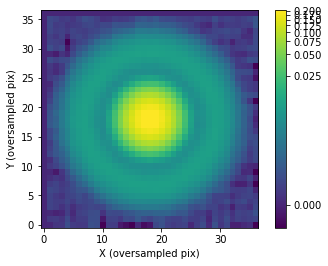

Recentering boxsize 6...


In [ ]:
sra=[]
tmpx = []; tmpy = [];
for i in range(3,11):
    print("Recentering boxsize {}...".format(i))
    sx, sy, sr, mx, my = func("image.13.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 4, 6, norm_radius=5.5, recentering_boxsize=i)
    tmpx.append(mx)
    tmpy.append(my)

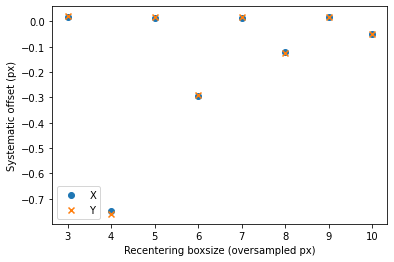

In [14]:
plt.scatter([3,4,5,6,7,8,9,10], tmpx, label='X')
plt.scatter([3,4,5,6,7,8,9,10], tmpy, marker='x', label='Y')
plt.xlabel('Recentering boxsize (oversampled px)')
plt.ylabel('Systematic offset (px)')
plt.legend()

It seems that the recentering_boxsize parameter should be an odd number.

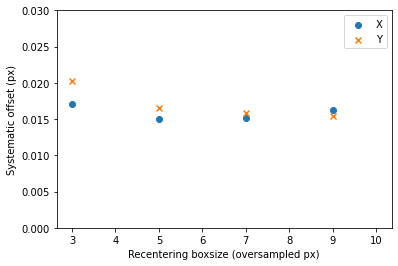

In [15]:
plt.scatter([3,4,5,6,7,8,9,10], tmpx, label='X')
plt.scatter([3,4,5,6,7,8,9,10], tmpy, marker='x', label='Y')
plt.xlabel('Recentering boxsize (oversampled px)')
plt.ylabel('Systematic offset (px)')
plt.ylim([-0.0,0.03])
plt.legend()

The systematic offset does not seem to depend on this parameter very much if the parameter is set to be an odd number. Does this offset depend on the distribution of stars?

## norm_radius = 2.5

In [16]:
def func(filename, sp_filename, n_oversample, n_maxiter, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    n_oversample: Oversampling setting for ePSF analysis.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
#    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
    mag = 13.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
#    plt.xlim([-0.01,0.04])
#    plt.ylim([-0.01,0.04])
    plt.show()
    
    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
#    plt.xlim([-0.5,0.5])
#    plt.ylim([-0.01,0.04])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()
    
#    plt.axes().set_aspect('equal')
#    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#               angles='xy', scale_units='xy', scale=0.0003)
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.xlim([0, 1920])
#    plt.ylim([0, 1920])
#    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
    meandx = np.mean(dx)
    meandy = np.mean(dy)
    return stddx, stddy, stddr, meandx, meandy

Iteration 1...


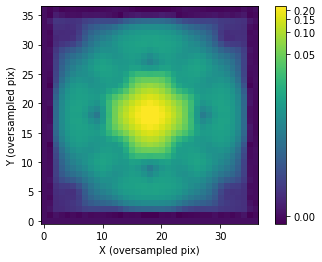

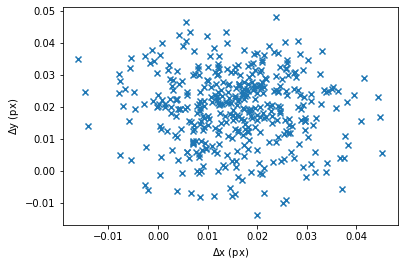

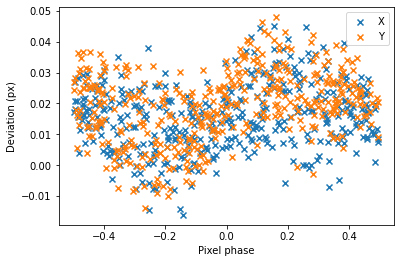

Iteration 2...


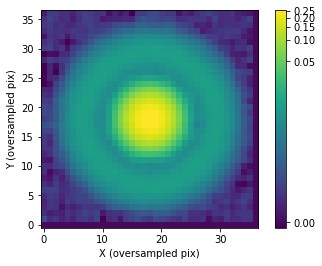

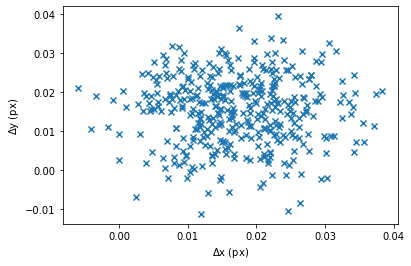

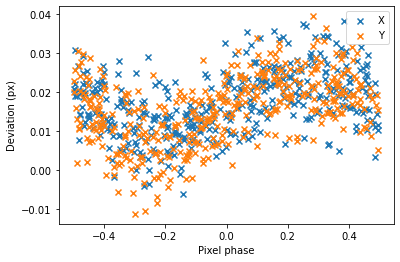

Iteration 3...


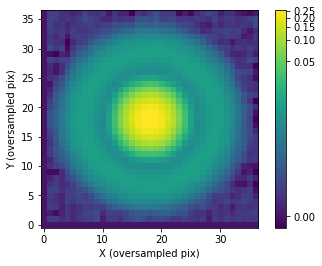

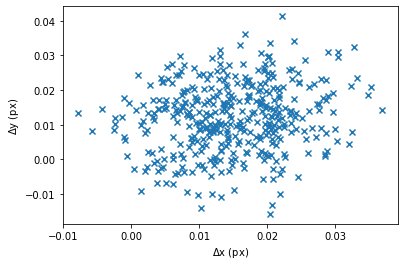

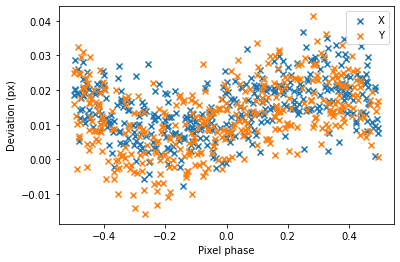

Iteration 4...


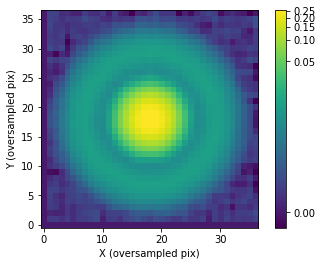

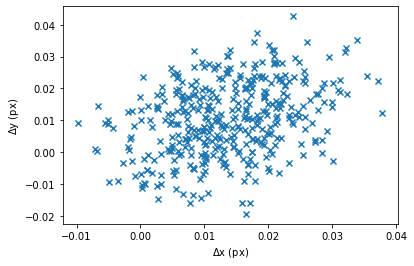

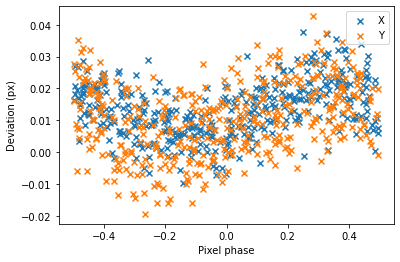

Iteration 5...


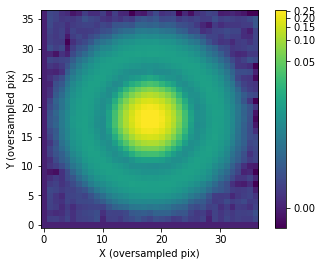

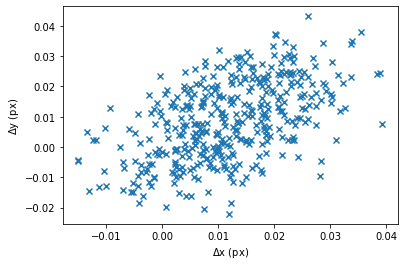

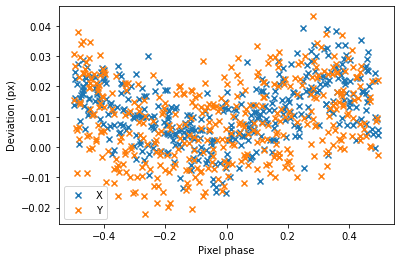

Iteration 6...


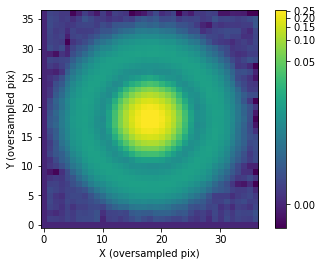

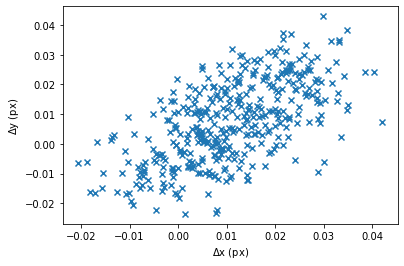

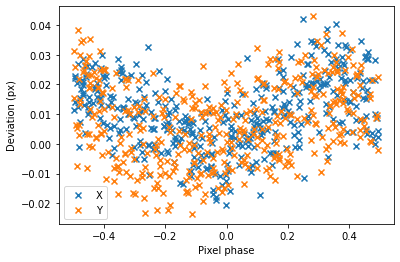

Iteration 7...


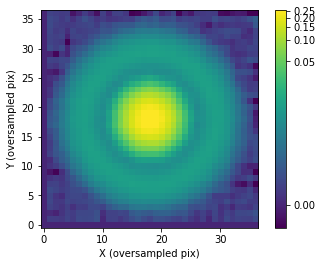

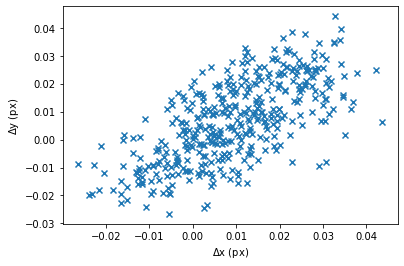

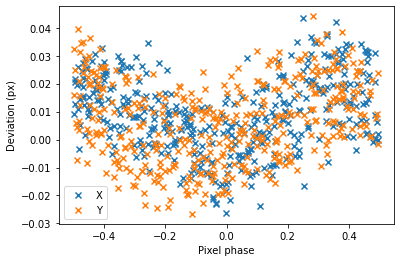

Iteration 8...


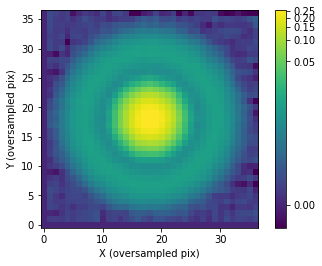

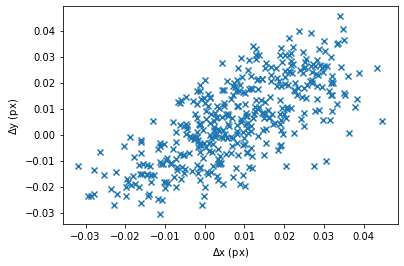

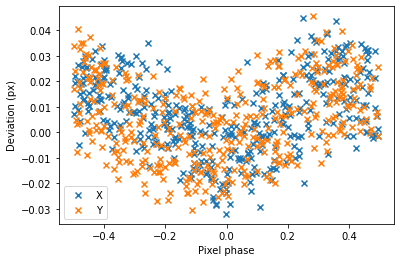

Iteration 9...


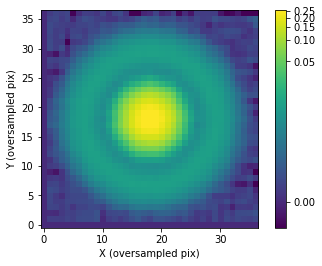

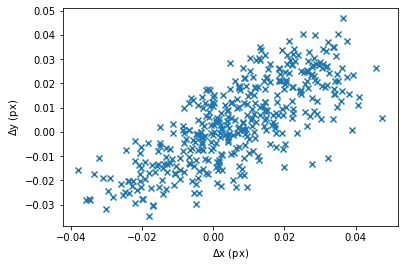

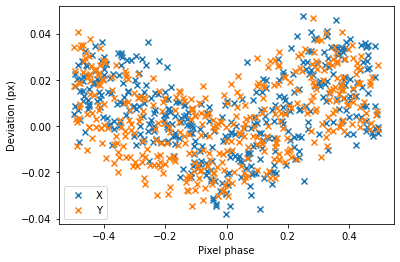

Iteration 10...


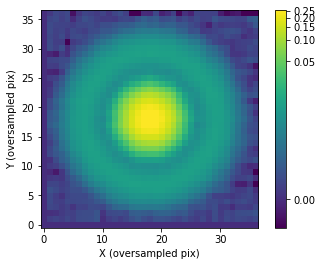

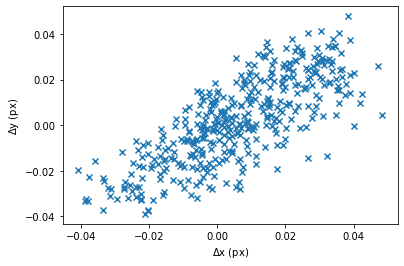

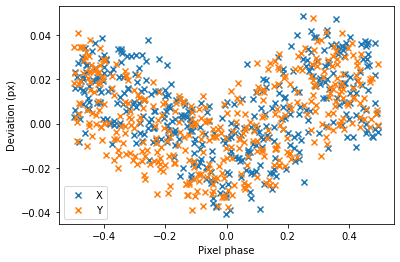

[0.010069892986208164, 0.007847217212136466, 0.008535697537103244, 0.009497956393050525, 0.010396298480624127, 0.01082274267556367, 0.011298830152008976, 0.011763940736073564, 0.012598531184580066, 0.013371735734657395]


In [17]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.13.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 4, i, norm_radius=2.5, recentering_boxsize=5)
    tmp.append(sr)
print(tmp)

A new significant systematic error is seen. This parameter seems to be also important to determine the residual systematics.

## norm_radius = 11.5

Iteration 1...


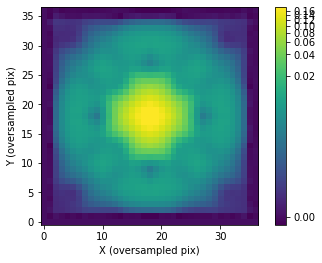

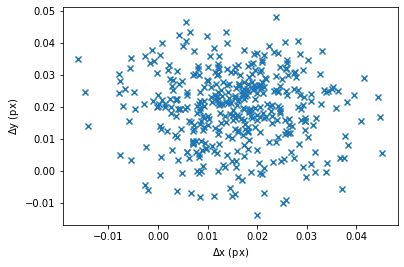

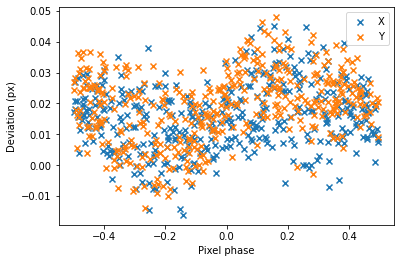

Iteration 2...


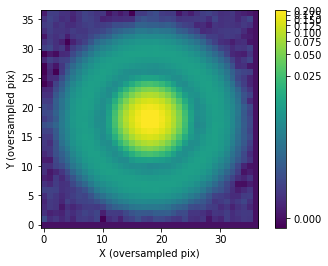

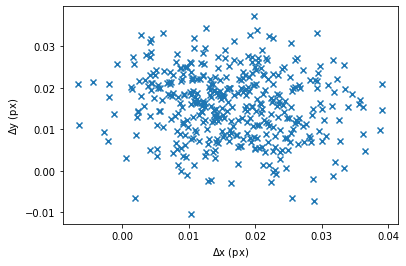

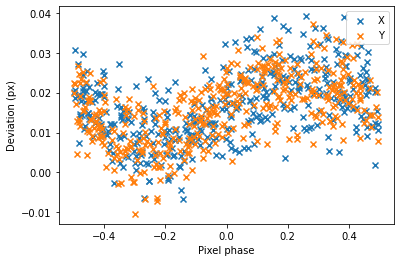

Iteration 3...


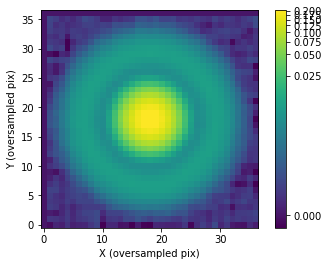

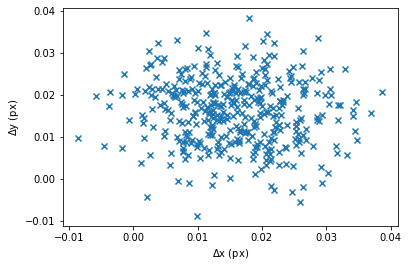

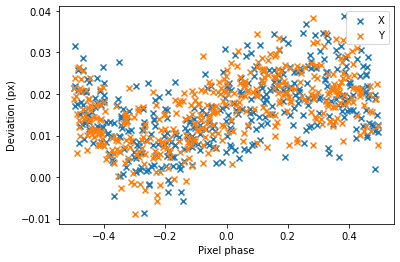

Iteration 4...


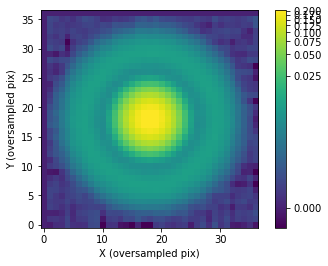

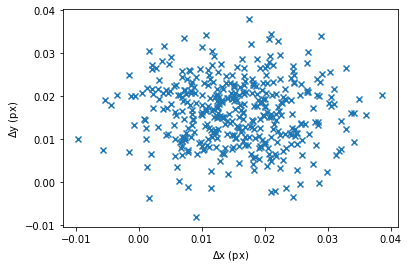

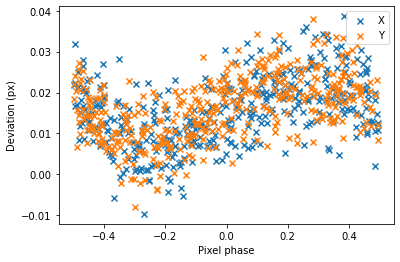

Iteration 5...


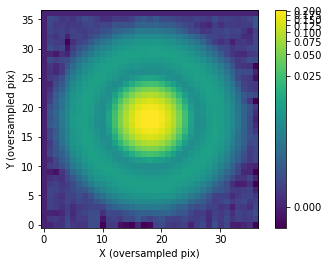

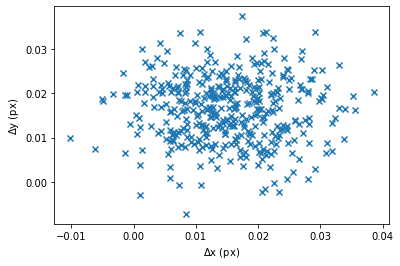

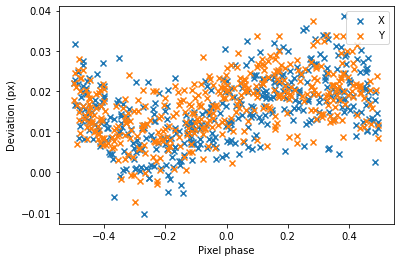

Iteration 6...


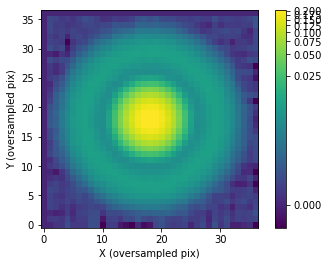

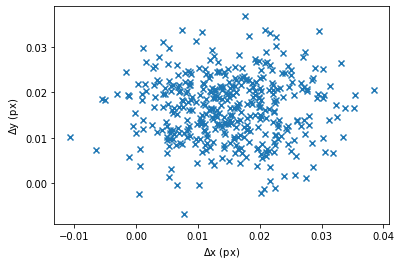

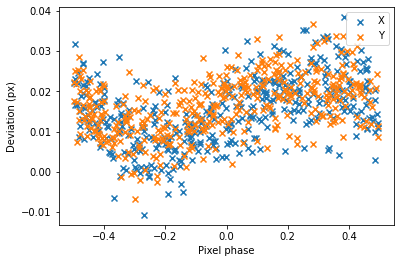

Iteration 7...


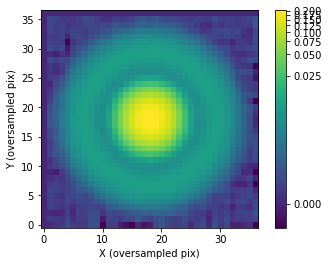

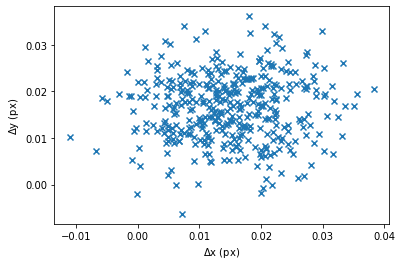

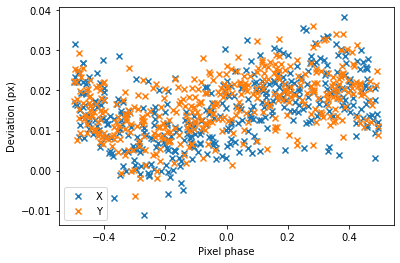

Iteration 8...


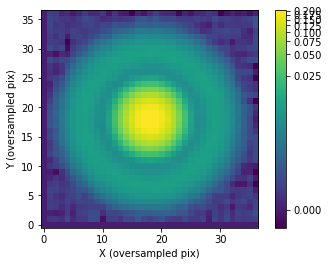

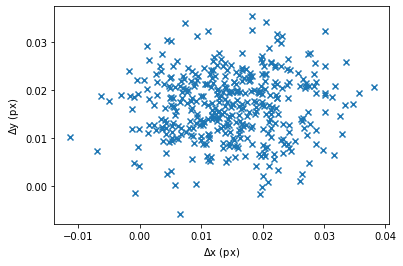

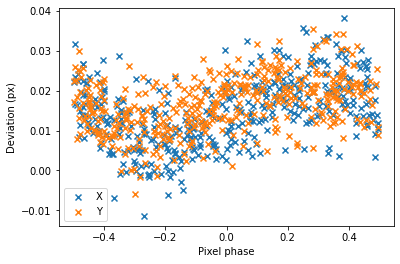

Iteration 9...


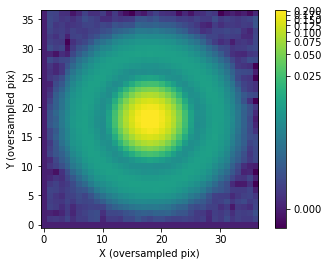

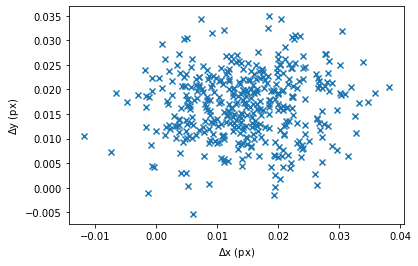

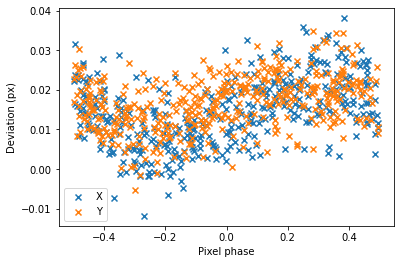

Iteration 10...


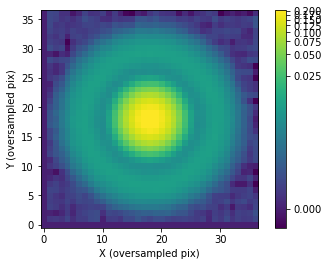

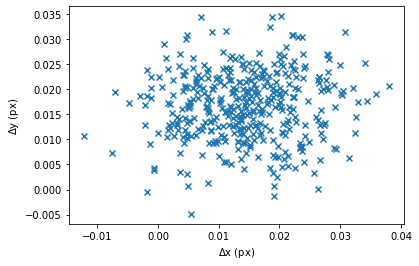

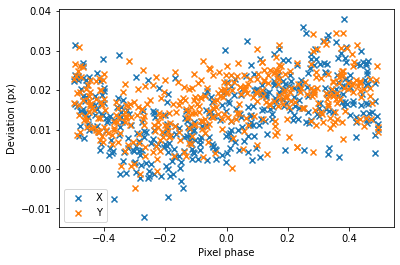

[0.01006990290331447, 0.007626345861962144, 0.007413286289961736, 0.007412767179899864, 0.0074352024710472335, 0.0074500337856345114, 0.007459607740906221, 0.007461420043685579, 0.007445986315012976, 0.0074225712363097576]


In [18]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.13.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 4, i, norm_radius=11.5, recentering_boxsize=5)
    tmp.append(sr)
print(tmp)

A small norm_radius of 2.5 caused systematic positional error. Such a small norm_radius can introduce systematic error in aperture photometry counts and cause systematic positional error. On the other hand, a large norm_radius did not cause such systematic error. It seems that the norm_radius value should be large enough compared to the central core of the ePSF. If objects are faint, too large values for norm_radius are expected to degrade the final positional accuracy because such settings lead to large noise in aperture photometry counts and bad normalization of the star images required to construct ePSF.